In [1]:
import xarray as xr
import pyproj
import rioxarray as rxr
from osgeo import gdal
import regionmask

import numpy as np
import pandas as pd 
import geopandas as gpd


from os import listdir, mkdir
from os.path import join, exists
import datetime 

import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import Point
from shapely.geometry import MultiPoint

import warnings

warnings.filterwarnings('ignore')


https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/mcd14dl-nrt

In [2]:
df = pd.read_csv('./DL_FIRE_M-C61_466007/fire_archive_M-C61_466007.csv')
df = df[(df.confidence>70)&(df.type==0)]
df

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
3,55.4456,-2.0814,311.2,1.2,1.1,2017-04-04,1315,Aqua,MODIS,71,6.03,278.2,16.5,D,0
4,55.4436,-2.1010,318.5,1.2,1.1,2017-04-04,1315,Aqua,MODIS,79,6.03,280.3,24.7,D,0
20,56.7464,-3.1443,313.1,1.0,1.0,2017-04-06,1303,Aqua,MODIS,73,6.03,287.4,12.1,D,0
31,51.8309,-3.4117,314.9,1.6,1.2,2017-04-07,2132,Terra,MODIS,90,6.03,274.3,34.6,N,0
34,54.7606,-1.9225,316.8,1.3,1.1,2017-04-08,1103,Terra,MODIS,77,6.03,289.5,20.8,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4368,51.9182,0.0239,328.4,1.1,1.1,2022-09-09,1243,Aqua,MODIS,86,6.03,289.1,29.2,D,0
4369,51.9154,0.0079,346.6,1.1,1.1,2022-09-09,1243,Aqua,MODIS,95,6.03,292.0,63.9,D,0
4371,51.9094,0.0009,309.1,2.4,1.5,2022-09-09,2047,Terra,MODIS,76,6.03,282.5,43.6,N,0
4373,51.9151,0.0021,314.0,2.4,1.5,2022-09-09,2047,Terra,MODIS,88,6.03,282.7,53.5,N,0


In [3]:
df2 = pd.read_csv('./DL_FIRE_M-C61_466007/fire_nrt_M-C61_466007.csv')
df2 = df2[(df2.confidence>70)]
df2

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
8,51.57500,-3.77322,319.56,1.03,1.01,2023-02-10,249,Aqua,MODIS,99,6.1NRT,271.79,23.55,N
16,54.81904,-2.06114,315.59,1.00,1.00,2023-02-14,1102,Terra,MODIS,76,6.1NRT,281.40,17.07,D
28,50.41081,-3.93813,328.38,2.24,1.45,2023-02-27,1146,Terra,MODIS,86,6.1NRT,280.35,97.74,D
29,50.40947,-3.93393,328.23,2.24,1.45,2023-02-27,1146,Terra,MODIS,86,6.1NRT,280.12,95.83,D
37,56.61486,-3.54446,326.55,3.08,1.67,2023-03-10,1409,Aqua,MODIS,80,6.1NRT,277.76,145.25,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,56.91247,-2.80033,312.98,1.20,1.09,2023-10-03,1121,Terra,MODIS,73,6.1NRT,284.62,18.20,D
523,52.95260,-0.11241,315.51,1.23,1.10,2023-10-29,1102,Terra,MODIS,76,6.1NRT,284.18,20.72,D
524,52.94933,-0.09505,347.95,1.23,1.10,2023-10-29,1102,Terra,MODIS,95,6.1NRT,285.60,80.86,D
525,52.95766,-0.10552,316.26,2.12,1.42,2023-10-29,2034,Terra,MODIS,93,6.1NRT,278.55,55.94,N


In [4]:
df = pd.concat([df[['latitude',	'longitude', 'acq_date']], df2[['latitude',	'longitude', 'acq_date']]])

<Axes: >

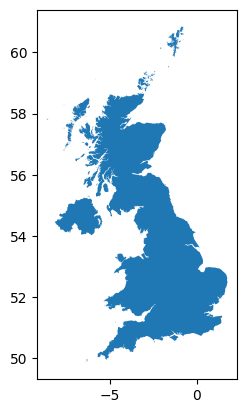

In [6]:
shape = gpd.read_file('./gadm41_GBR_shp/gadm41_GBR_0.shp')
shape.plot()

In [7]:
df['geometry'] = df.apply(lambda x: Point(x['longitude'],x['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df.reset_index(drop=True))#.set_crs(shape.crs)
#gdf = gpd.sjoin(gdf, shape[['geometry','NAME_1']], how='inner', op='intersects')
gdf

,latitude,longitude,acq_date,geometry
0,55.44560,-2.08140,2017-04-04,POINT (-2.08140 55.44560)
1,55.44360,-2.10100,2017-04-04,POINT (-2.10100 55.44360)
2,56.74640,-3.14430,2017-04-06,POINT (-3.14430 56.74640)
3,51.83090,-3.41170,2017-04-07,POINT (-3.41170 51.83090)
4,54.76060,-1.92250,2017-04-08,POINT (-1.92250 54.76060)
...,...,...,...,...
1082,56.91247,-2.80033,2023-10-03,POINT (-2.80033 56.91247)
1083,52.95260,-0.11241,2023-10-29,POINT (-0.11241 52.95260)
1084,52.94933,-0.09505,2023-10-29,POINT (-0.09505 52.94933)
1085,52.95766,-0.10552,2023-10-29,POINT (-0.10552 52.95766)


In [5]:
df.reset_index(drop=True).to_csv('fires_uk.csv', index=False)

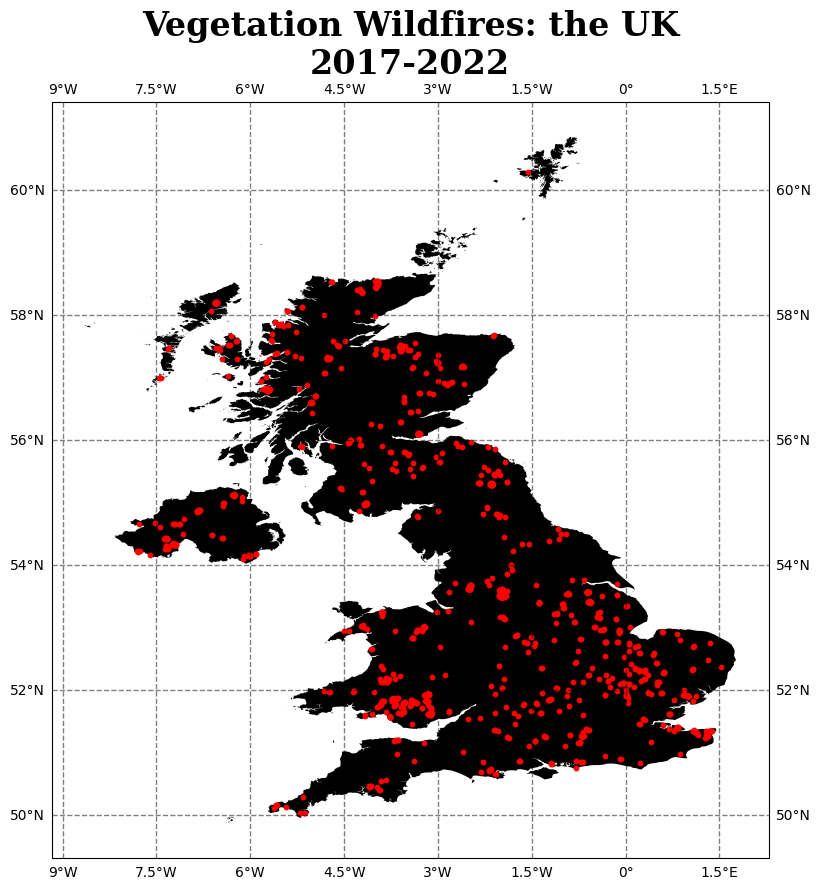

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 9))
        
#ax.set_extent([80, 160, 52 ,75])
shape.geometry.plot(ax=ax, color='black')

#e[1]['t2m'][0].where(rg).plot(ax=ax)
gdf.geometry.plot(ax=ax, color='red', markersize=10)

ax.gridlines(draw_labels=True,linewidth=1, alpha=0.5, linestyle='--', color='black')

ax.set_title(f'Vegetation Wildfires: the UK\n2017-2022', fontsize=24, fontdict={'fontweight': 'semibold', 'fontfamily':'serif'})
#plt.savefig(f'Thermal anomalies_29.07-21.08.201.jpg')
plt.tight_layout()
plt.show()

<Axes: >

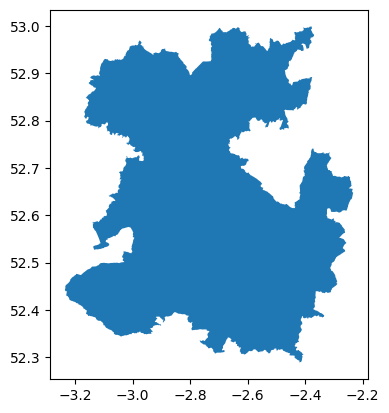

In [54]:
adm3 = gpd.read_file('./gadm41_GBR_shp/gadm41_GBR_3.shp')
adm3[adm3['NAME_3']=='Shropshire'].plot()

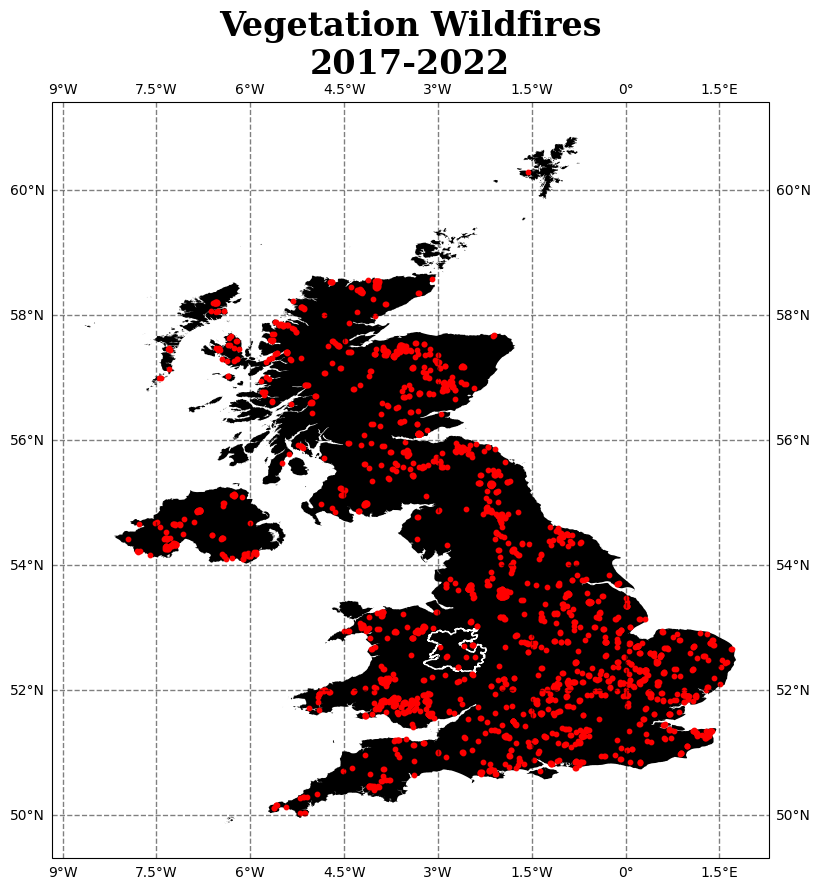

In [74]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 9))
        
#ax.set_extent([80, 160, 52 ,75])
shape.geometry.plot(ax=ax, color='black')
adm3[adm3['NAME_3']=='Shropshire'].plot(color='black', edgecolor="white", ax=ax)
#e[1]['t2m'][0].where(rg).plot(ax=ax)
gdf.geometry.plot(ax=ax, color='red', markersize=10)

ax.gridlines(draw_labels=True,linewidth=1, alpha=0.5, linestyle='--', color='black')

ax.set_title(f'Vegetation Wildfires\n2017-2022', fontsize=24, fontdict={'fontweight': 'semibold', 'fontfamily':'serif'})
#plt.savefig(f'Thermal anomalies_29.07-21.08.201.jpg')
plt.tight_layout()
plt.show()

In [87]:
shr_mask = gdf.geometry.within(adm2[adm2['NAME_3']=='Shropshire'].geometry.values[0])
shr = gdf.loc[shr_mask]

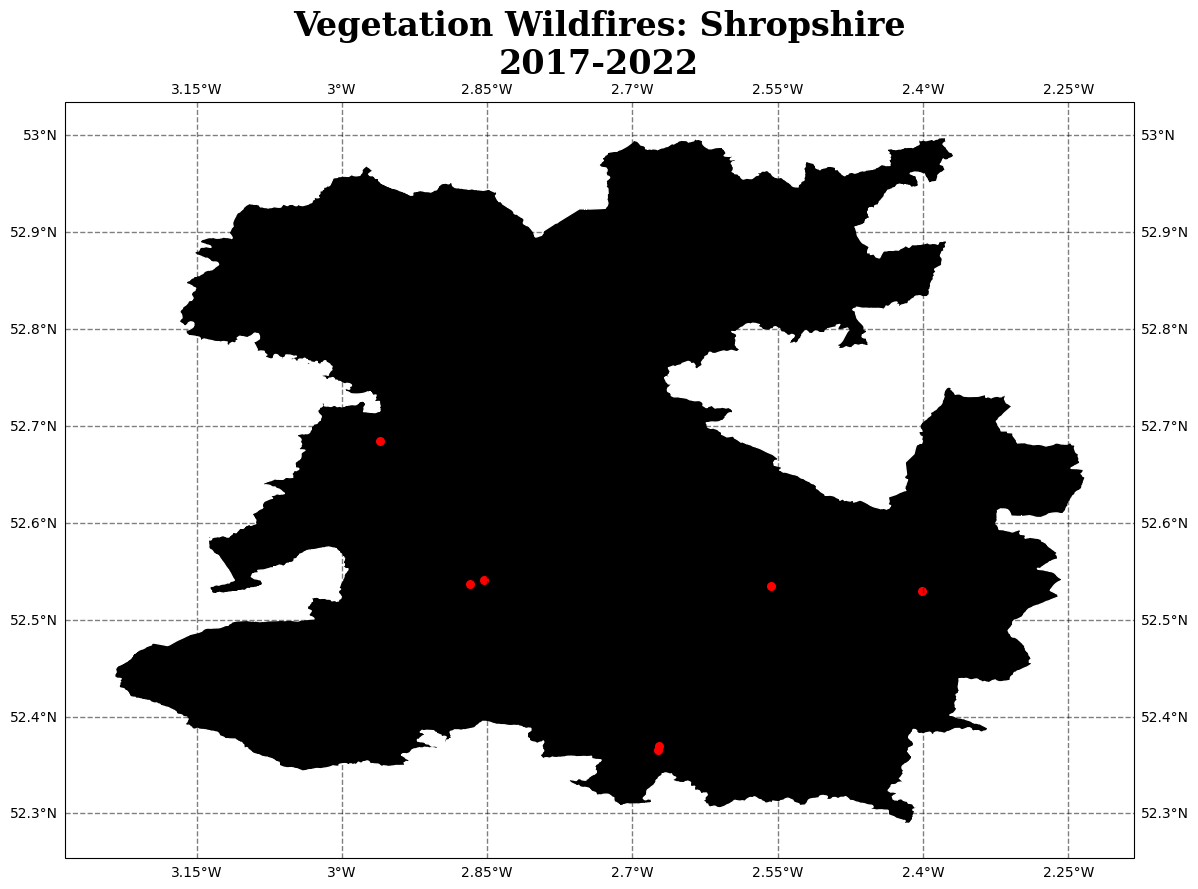

In [85]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16, 9))
        
#ax.set_extent([-4.5, 1.5, 52 ,54])
#shape.geometry.plot(ax=ax, color='black')
adm3[adm3['NAME_3']=='Shropshire'].plot(color='black', edgecolor="white", ax=ax)
shr.geometry.plot(ax=ax, color='red', markersize=30)

ax.gridlines(draw_labels=True,linewidth=1, alpha=0.5, linestyle='--', color='black')

ax.set_title(f'Vegetation Wildfires: Shropshire\n2017-2022', fontsize=24, fontdict={'fontweight': 'semibold', 'fontfamily':'serif'})
#plt.savefig(f'Thermal anomalies_29.07-21.08.201.jpg')
plt.tight_layout()
plt.show()